# Human Activity Classification from Accelerometer Time-series data

Sai Surya Nattuva <br />
Advisor: Prof Gokhan Kul <br />
University of Massachusetts Dartmouth <br />
<br />
<p>Human activity can be observed and measured by employing different sensors on different parts of the body. An increase in the usage of wearable devices by people has led to increased research in Human Activity monitoring and analysis. This analysis has helped develop many technologies like fall detection, irregular heart rhythms, walking steadiness, posture, etc. This project focuses on classifying the activity performed by a human from time-series data generated from the user's phone's accelerometer. The time-series data is first converted into 2-D images and then fed to a CNN to learn five different activities from 4 features of the data. The project's primary focus is to leverage the predicting power of CNNs on time-series data with a small number of training samples and input channels. </p>



# References
> A. Jafari, A. Ganesan, C. S. K. Thalisetty, V. Sivasubramanian, T. Oates and T. Mohsenin, "SensorNet: A Scalable and Low-Power Deep Convolutional Neural Network for Multimodal Data Classification," in IEEE Transactions on Circuits and Systems I: Regular Papers, vol. 66, no. 1, pp. 274-287, Jan. 2019, doi: 10.1109/TCSI.2018.2848647.

> SensorNet: An Educational Deep
Neural Network Framework for
Low Power Multimodal Data
Classification, http://eehpc.csee.umbc.edu/publications/pdf/2020/Sensornet_Book_chapter.pdf

> Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011. 

### Imports


In [1]:
import numpy as np
from sklearn.preprocessing import normalize
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, classification_report
from sklearn.model_selection import RandomizedSearchCV

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import json

import datetime
import time

import matplotlib.pyplot as plt
from itertools import cycle

# Loading the data

In [2]:
file_data = pd.read_csv("../data/phone data/dat_cumulative_rounded_tstamp_labeled.csv")

file_data.describe()

,ID,time,gFx,gFy,gFz,TgF,label
count,10608.000000,10608.000000,10608.000000,10608.000000,10608.000000,10608.000000,10608.000000
mean,5303.500000,54.655169,0.582059,0.701431,0.307485,2.828883,1.164216
std,3062.410162,31.539141,2.465442,2.294758,2.321981,3.107790,1.505401
min,0.000000,0.001790,-7.990500,-8.008200,-8.028300,0.060000,0.000000
25%,2651.750000,27.366578,-0.417400,0.275900,-0.441450,0.990000,0.000000
50%,5303.500000,54.668020,-0.082650,0.802700,0.012300,1.210000,0.000000
75%,7955.250000,81.955535,0.612875,1.105700,0.703400,3.400000,2.000000
max,10607.000000,109.242540,8.008100,7.996600,7.976600,13.850000,4.000000


# Helping functions

In [3]:
# Function to one-hot encoding

def onehot(labels):
    enc = OneHotEncoder() 
    enc.fit(np.unique(labels).reshape(-1, 1))
    labels = enc.transform(labels.reshape(-1, 1)).toarray() 
    num_classes = labels.shape[1]
    print("Total Number of classes: " + str(num_classes))
    return labels

In [4]:
# Function to create windows

def Windowing(window_size,step_size,data,label):
    window_labels = np.zeros([0, label.shape[-1]])
    t_data = np.transpose(data)
    shape = (int((t_data.shape[-1] - window_size)/step_size) + 1,)+ t_data.shape[:-1] + (window_size, )
    strides = (t_data.strides[-1] * step_size,) + t_data.strides 
    window_images = np.lib.stride_tricks.as_strided(t_data, shape=shape, strides=strides)
    window_labels = np.append(window_labels, label[window_size - 1:len(label):step_size, :],axis=0)
    return window_images, window_labels

In [5]:
# Function to segment the data

def dataset_segmentation(data,label, t_prop = 0.65, v_prop = 0.1):
    config_str = []
    ratio_t = t_prop
    ratio_v = v_prop
    valid_d = data[int(ratio_t * len(data)): int((ratio_t + ratio_v) * len(data)),:]
    valid_l = label[int(ratio_t * len(data)): int((ratio_t + ratio_v) * len(data))] 
    config_str.append('Validation set shape:')
    config_str.append(valid_d.shape)
    config_str.append('Validation set label shape:')
    config_str.append(valid_l.shape)
    test_d = data[int((ratio_t + ratio_v) * len(data)): len(data),:]
    test_l= label[int((ratio_t + ratio_v) * len(data)): len(data)] 
    config_str.append('Test set shape:')
    config_str.append(test_d.shape)
    config_str.append('Test set label shape:')
    config_str.append(test_l.shape)
    train_d = data[0:int(ratio_t * len(data)),:]
    train_l = label[0:int(ratio_t * len(label))] 
    config_str.append('Training set shape:')
    config_str.append(train_d.shape)
    config_str.append('Training set label shape:')
    config_str.append(train_l.shape)
    print("\n".join([str(s) for s in config_str]))
    return train_d,train_l,valid_d,valid_l,test_d,test_l, config_str

In [6]:
# Compute ROC curve and ROC area for each class

def plot_roc(n_classes, test_l, pred_scores, timestr):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    lw = 1.5

    test_l_onehot = onehot(test_l)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_l_onehot[:, i], pred_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(test_l_onehot.ravel(), pred_scores.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10, 6))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=2.5,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=2.5,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "forestgreen", "gold"])
    for i, color, cls_label in zip(range(n_classes), colors, ['Idle','Cross','Hook','Jab','Uppercut']):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC of {0} (AUC = {1:0.2f})".format(cls_label, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristics")
    plt.legend(loc="lower right")
    # plt.show()
    plt.savefig(f'../results/ROC-{timestr}.png')
    

# Hyperparameter Tuning

In [7]:
def build_model(filters, kernel_size, inner_kernel_size, activation, input_shape, optimizer, loss):
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(int(filters), kernel_size, activation=activation, input_shape= input_shape,data_format='channels_last'))
    model.add(tf.keras.layers.Conv2D(int(filters/2), inner_kernel_size, activation=activation))
    
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(1, 2),strides=(1,2)))
    
    model.add(tf.keras.layers.Conv2D(int(filters/2), inner_kernel_size, activation=activation))
    model.add(tf.keras.layers.Conv2D(int(filters/4), inner_kernel_size, activation=activation))
    
    model.add(tf.keras.layers.MaxPooling2D((1,2),strides=(1,2)))
    
    model.add(tf.keras.layers.Conv2D(int(filters/4), inner_kernel_size, activation=activation))
    
    model.add(tf.keras.layers.MaxPooling2D((1,2),strides=(1,2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation=activation))
    model.add(tf.keras.layers.Dense(5, activation='softmax'))

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model


In [ ]:
window_step_sizes = [64, 128]
step_sizes = [32, 16]
t_prop = 0.65
v_prop = 0.1

param_grid = {
    'filters': [64, 16, 32, 128],
    'kernel_size': [(4, 5), (1, 5)], 
    'inner_kernel_size': [(1, 5)], 
    'activation': ['relu', 'tanh'],
    'optimizer': ['Adam', 'RMSProp', 'SGD'], 
    'loss': ['sparse_categorical_crossentropy', 'categorical_crossentropy'],
    'epochs': [e for e in range(50, 201, 50)],
    'batch_size': [16, 32, 64, 128]
}

# reinitializing the data from file data
norm_data = normalize(file_data.iloc[:,2:6], axis=0)
print('Data shape', norm_data.shape)
norm_label = file_data.iloc[:, -1].to_numpy()
print('Label shape', norm_label.shape)
norm_label = onehot(norm_label)
print('One-hot Label shape', norm_label.shape)

grid = {}
grid_result = {}
grid_params = {}
accuracy = {}

for window_size in window_step_sizes:
    for step_size in step_sizes:
        [data,label] = Windowing(window_size,step_size,norm_data,norm_label)

        # to expand the dimensions of the data to feed to the CNN
        data = np.expand_dims(data, -1)
        
        # need to convert the label array back to class labels from one-hot encoding(used to create windows)
        label = np.argmax(label, axis=1)
        print(label.shape)
        
        print('Dataset Configurations')
        [train_d,train_l,valid_d,valid_l,test_d,test_l, _] = dataset_segmentation(data,label, t_prop, v_prop)
        
        param_grid['input_shape'] = [(4,window_size,1)]
        
        grid[(window_size, step_size)] = RandomizedSearchCV(estimator=KerasClassifier(build_fn=build_model, epochs=200, batch_size=32, verbose=1), cv=2, param_distributions=param_grid, 
                          verbose=5,  n_iter=20, n_jobs=1, scoring='accuracy')
        
        
        grid_result[(window_size, step_size)] = grid[(window_size, step_size)].fit(train_d, train_l)
        
        grid_params[(window_size, step_size)] = grid[(window_size, step_size)].best_params_
        pred = grid_result[(window_size, step_size)].predict(test_d)
        print(pred)
        
        accuracy[(window_size, step_size)] = f1_score(test_l, pred, average='micro')
        

with open('../results/grid.py', 'a') as f:
    f.write(str(datetime.datetime.now()) + '\n')
    f.write(str(grid))
    f.write('\n\n')
    
with open('../results/grid_result.py', 'a') as f:
    f.write(str(datetime.datetime.now()) + '\n')
    f.write(str(grid_result))
    f.write('\n\n')
    
    
with open('../results/grid_params.py', 'a') as f:
    f.write(str(datetime.datetime.now()) + '\n')
    f.write(str(grid_params))
    f.write('\n\n')
    
with open('../results/accuracy.py', 'a') as f:
    f.write(str(datetime.datetime.now()) + '\n')
    f.write(str(accuracy))
    f.write('\n\n')
    

#### Best Parameters
- 'optimizer': 'Adam',
- 'loss': 'sparse_categorical_crossentropy',
- 'kernel_size': (4, 5),
- 'input_shape': (4, 64, 1),
- 'inner_kernel_size': (1, 5),
- 'filters': 64,
- 'activation': 'relu'

# Training and testing the model with the best parameters

Data shape (10608, 4)
Label shape (10608,)
Total Number of classes: 5
One-hot Label shape (10608, 5)
(330,)
Dataset Configurations
Validation set shape:
(50, 4, 64, 1)
Validation set label shape:
(50,)
Test set shape:
(99, 4, 64, 1)
Test set label shape:
(99,)
Training set shape:
(181, 4, 64, 1)
Training set label shape:
(181,)


2022-05-03 15:21:59.968013: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-03 15:21:59.968669: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Train on 181 samples, validate on 50 samples
Epoch 1/150
181/181 [==============================] - 2s 9ms/sample - loss: 1.6035 - accuracy: 0.5249 - val_loss: 1.5947 - val_accuracy: 0.6200
Epoch 2/150
181/181 [==============================] - 0s 671us/sample - loss: 1.5869 - accuracy: 0.6077 - val_loss: 1.5747 - val_accuracy: 0.6200
Epoch 3/150
181/181 [==============================] - 0s 669us/sample - loss: 1.5625 - accuracy: 0.6077 - val_loss: 1.5442 - val_accuracy: 0.6200
Epoch 4/150
181/181 [==============================] - 0s 647us/sample - loss: 1.5201 - accuracy: 0.6077 - val_loss: 1.4761 - val_accuracy: 0.6200
Epoch 5/150
181/181 [==============================] - 0s 620us/sample - loss: 1.4160 - accuracy: 0.6077 - val_loss: 1.3210 - val_accuracy: 0.6200
Epoch 6/150
181/181 [==============================] - 0s 617us/sample - loss: 1.2393 - accuracy: 0.6077 - val_loss: 1.2066 - val_accuracy: 0.6200
Epoch 7/150
181/181 [==============================] - 0s 604us/sample - lo

181/181 [==============================] - 0s 523us/sample - loss: 0.6354 - accuracy: 0.7735 - val_loss: 0.8745 - val_accuracy: 0.7600
Epoch 57/150
181/181 [==============================] - 0s 522us/sample - loss: 0.6386 - accuracy: 0.7790 - val_loss: 0.8979 - val_accuracy: 0.7600
Epoch 58/150
181/181 [==============================] - 0s 593us/sample - loss: 0.6305 - accuracy: 0.7901 - val_loss: 1.0114 - val_accuracy: 0.7200
Epoch 59/150
181/181 [==============================] - 0s 587us/sample - loss: 0.7119 - accuracy: 0.7238 - val_loss: 0.9244 - val_accuracy: 0.7400
Epoch 60/150
181/181 [==============================] - 0s 569us/sample - loss: 0.7092 - accuracy: 0.7735 - val_loss: 0.9462 - val_accuracy: 0.7000
Epoch 61/150
181/181 [==============================] - 0s 560us/sample - loss: 0.6724 - accuracy: 0.7624 - val_loss: 0.9082 - val_accuracy: 0.7400
Epoch 62/150
181/181 [==============================] - 0s 583us/sample - loss: 0.6514 - accuracy: 0.7680 - val_loss: 0.8426 

181/181 [==============================] - 0s 598us/sample - loss: 0.2351 - accuracy: 0.9392 - val_loss: 1.5603 - val_accuracy: 0.7200
Epoch 112/150
181/181 [==============================] - 0s 695us/sample - loss: 0.2352 - accuracy: 0.9392 - val_loss: 1.3922 - val_accuracy: 0.7400
Epoch 113/150
181/181 [==============================] - 0s 640us/sample - loss: 0.2459 - accuracy: 0.9282 - val_loss: 1.6239 - val_accuracy: 0.7200
Epoch 114/150
181/181 [==============================] - 0s 558us/sample - loss: 0.2403 - accuracy: 0.9282 - val_loss: 1.5103 - val_accuracy: 0.7400
Epoch 115/150
181/181 [==============================] - 0s 571us/sample - loss: 0.2427 - accuracy: 0.9337 - val_loss: 1.5559 - val_accuracy: 0.7200
Epoch 116/150
181/181 [==============================] - 0s 622us/sample - loss: 0.2159 - accuracy: 0.9337 - val_loss: 1.5715 - val_accuracy: 0.7400
Epoch 117/150
181/181 [==============================] - 0s 632us/sample - loss: 0.2317 - accuracy: 0.9171 - val_loss: 1

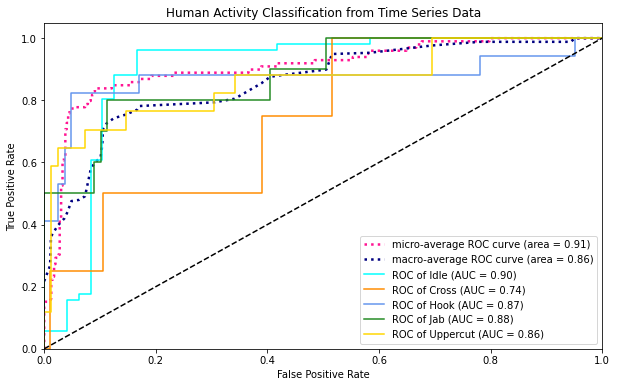

In [9]:
strt_time = time.time()

window_size = 64
step_size = 32
epochs = 150
batch_size = 32
best_params = {
    'optimizer': 'Adam',
    'loss': 'sparse_categorical_crossentropy', 
    'kernel_size': (4, 5), 
    'input_shape': (4, 64, 1), 
    'inner_kernel_size': (1, 5), 
    'filters': 64, 
    'activation': 'relu'
    }
t_prop = 0.55
v_prop = 0.15

# reinitializing the data from file data
norm_data = normalize(file_data.loc[:,['gFx', 'gFy', 'gFz', 'TgF']], axis=0)
print('Data shape', norm_data.shape)
norm_label = file_data.loc[:, 'label'].to_numpy()
print('Label shape', norm_label.shape)
norm_label = onehot(norm_label)
print('One-hot Label shape', norm_label.shape)

[data,label] = Windowing(window_size,step_size,norm_data,norm_label)

# to expand the dimensions of the data to feed to the CNN
data = np.expand_dims(data, -1)

# need to convert the label array back to class labels from one-hot encoding(used to create windows)
label = np.argmax(label, axis=1)
print(label.shape)

# # plotting class distribution
# pd.DataFrame(label).iloc[:, 0].map({0: 'Transcient', 1: 'Cross', 2: 'Hook', 3: 'Jab', 4: 'Uppercut'}).value_counts().plot(kind = 'bar', title='Class distribution')

print('Dataset Configurations')
[train_d,train_l,valid_d,valid_l,test_d,test_l, config_str] = dataset_segmentation(data,label, t_prop, v_prop)

# # plotting train data class distribution
# pd.DataFrame(train_l).iloc[:, 0].map({0: 'Transcient', 1: 'Cross', 2: 'Hook', 3: 'Jab', 4: 'Uppercut'}).value_counts().plot(kind = 'bar', title='Class distribution')

# # plotting validation data class distribution
# pd.DataFrame(valid_l).iloc[:, 0].map({0: 'Transcient', 1: 'Cross', 2: 'Hook', 3: 'Jab', 4: 'Uppercut'}).value_counts().plot(kind = 'bar', title='Class distribution')

# # plotting test data class distribution
# pd.DataFrame(test_l).iloc[:, 0].map({0: 'Transcient', 1: 'Cross', 2: 'Hook', 3: 'Jab', 4: 'Uppercut'}).value_counts().plot(kind = 'bar', title='Class distribution')

best_model = tf.keras.Sequential()
best_model.add(tf.keras.layers.Conv2D(64, (4, 5), activation='relu', input_shape= (4,64,1),data_format='channels_last'))
best_model.add(tf.keras.layers.Conv2D(32, (1, 5), activation='relu'))
best_model.add(tf.keras.layers.MaxPooling2D(pool_size=(1, 2),strides=(1,2)))
best_model.add(tf.keras.layers.Conv2D(32, (1, 5), activation='relu'))
best_model.add(tf.keras.layers.Conv2D(16, (1, 5), activation='relu'))
best_model.add(tf.keras.layers.MaxPooling2D((1,2),strides=(1,2)))
best_model.add(tf.keras.layers.Conv2D(16, (1, 5), activation='relu'))
best_model.add(tf.keras.layers.MaxPooling2D((1,2),strides=(1,2)))
best_model.add(tf.keras.layers.Flatten())
best_model.add(tf.keras.layers.Dense(64, activation='relu'))
best_model.add(tf.keras.layers.Dense(5, activation='softmax'))

best_model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
best_model.fit(train_d, train_l, epochs=150, batch_size = 32, validation_data=(valid_d, valid_l))
print(best_model.metrics)

pred_scores = best_model.predict(test_d)
pred = np.argmax(pred_scores, axis=-1)
accuracy = classification_report(test_l, pred, target_names=['Idle','Cross','Hook','Jab','Uppercut'])
timestr = time.strftime("%Y%m%d-%H%M%S") # timestamp for files

print(accuracy)

with open('../results/f1.py', 'a') as f:
    f.write(str(datetime.datetime.now()) + '\n')
    f.write(str(accuracy))
    f.write('\n\n')
    
with open(f'../results/model-{timestr}.json', 'w') as f:    
    f.write(best_model.to_json(indent = 2))

best_model.save(f'../models/model-{timestr}.h5')

with open(f'../results/data-config-{timestr}.txt', 'w') as f:    
    f.write("\n".join([str(s) for s in config_str]))
    
plot_roc(5, test_l, pred_scores, timestr)

print('\n===========================================')
print(f'Runtime is {time.time() - strt_time} secs')
print('===========================================\n')
